In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.preprocessing import PowerTransformer
from scipy import stats
from scipy.stats import norm
%matplotlib inline

## 1. Understanding the dataset

### 1.1 Top level overview

In [2]:
data = pd.read_csv("https://github.com/raintelia/task1/blob/main/Test.csv?raw=true", decimal = '.', sep = ',')

* **order_id_new, order_try_id_new** - id of an order
* **calc_created** - time when the order was created
* **metered_price, distance, duration** - actual price, distance and duration of a ride
* **upfront_price** - promised to the rider price, based on predicted duration (predicted_duration) and distance (predicted_distance)
* **distance** - ride distance
* **duration** - ride duration
* **gps_confidence** - indicator for good GPS connection (1 - good one, 0 - bad one)
* **entered_by** - who entered the address
* **b_state** - state of a ride (finished implies that the ride was actually done)
* **dest_change_number** - number of destination changes by a rider and a driver. It includes the original input of the destination by a rider. That is why the minimum value of it is 1
* **predicted distance** - predicted duration of a ride based on the pickup and dropoff points entered by the rider requesting a car
* **predicted duration** - predicted duration of a ride based on the pickup and dropoff points entered by the rider requesting a car
* **prediction_price_type** - internal variable for the type of prediction:
    * upfront, prediction - prediction happened before the ride
    * upfront_destination_changed - prediction happened after rider changed destination during the ride
* **change_reason_pricing** - indicates whose action triggered a change in the price prediction. If it is empty, it means that either nobody changed the destination or that the change has not affected the predicted price
* **ticket_id_new** - id for customer support ticket
* **device_token, device_token_new** - id for a device_token (empty for all the fields)
* **rider_app_version** - app version of rider phone
* **driver_app_version** - app version of driver phone
* **driver_device_uid_new** - id for UID of a phone device
* **device_name** - the name of the phone
* **eu_indicator** - whether a ride happens in EU
* **overpaid_ride_ticket** - indicator for a rider complaining about the overpaid ride
* **fraud_score** - fraud score of a rider. The higher it is the more likely the rider will cheat.

In [3]:
pd.set_option("display.max_columns", None)
data.head(10)

,order_id_new,order_try_id_new,calc_created,metered_price,upfront_price,distance,duration,gps_confidence,entered_by,b_state,dest_change_number,prediction_price_type,predicted_distance,predicted_duration,change_reason_pricing,ticket_id_new,device_token,rider_app_version,order_state,order_try_state,driver_app_version,driver_device_uid_new,device_name,eu_indicator,overpaid_ride_ticket,fraud_score
0,22,22,2020-02-02 3:37:31,4.04,10.0,2839,700,1,client,finished,1,upfront,13384.0,1091.0,NaN,1376,NaN,CI.4.17,finished,finished,DA.4.37,1596,Xiaomi Redmi 6,1,0,-1383.0
1,618,618,2020-02-08 2:26:19,6.09,3.6,5698,493,1,client,finished,1,upfront,2286.0,360.0,NaN,2035,NaN,CA.5.43,finished,finished,DA.4.39,1578,Samsung SM-G965F,1,0,NaN
2,657,657,2020-02-08 11:50:35,4.32,3.5,4426,695,1,client,finished,1,upfront,4101.0,433.0,NaN,2222,NaN,CA.5.43,finished,finished,DA.4.37,951,Samsung SM-A530F,1,0,-166.0
3,313,313,2020-02-05 6:34:54,72871.72,NaN,49748,1400,0,client,finished,2,upfront_destination_changed,3017.0,600.0,client_destination_changed,1788,NaN,CA.5.23,finished,finished,DA.4.37,1587,TECNO-Y6,0,1,NaN
4,1176,1176,2020-02-13 17:31:24,20032.50,19500.0,10273,5067,1,client,finished,1,upfront,14236.0,2778.0,NaN,2710,NaN,CA.5.04,finished,finished,DA.4.37,433,Itel W5504,0,0,NaN
5,1209,1209,2020-02-14 1:27:01,6.11,6.3,4924,513,1,client,finished,1,upfront,4882.0,562.0,NaN,2732,NaN,CA.5.04,finished,finished,DA.4.39,1591,HUAWEI WAS-LX1,1,0,NaN
6,761,761,2020-02-09 6:51:20,20753.20,10500.0,10459,1874,1,client,finished,1,upfront,4892.0,698.0,NaN,2173,NaN,CI.4.17,finished,finished,DA.4.19,982,TECNO MOBILE LIMITED TECNO KA7O,0,0,NaN
7,1662,1662,2020-02-17 18:24:45,2.61,6.5,2020,412,1,client,finished,1,upfront,8545.0,888.0,NaN,3229,NaN,CI.4.18,finished,finished,DA.4.37,1701,Samsung SM-N950F,1,0,-2350.0
8,1904,1904,2020-02-20 16:38:34,13600.50,NaN,9540,1917,1,client,finished,1,prediction,11018.0,1914.0,NaN,3557,NaN,CA.5.40,finished,finished,DA.4.31,605,TECNO K7,0,0,NaN
9,1999,1999,2020-02-21 11:02:38,4.14,2.5,3845,720,1,client,finished,1,upfront,1883.0,298.0,NaN,3631,NaN,CI.4.18,finished,finished,DA.4.39,1960,Samsung SM-G930F,1,0,-5181.0


**A quick glance at the dataset hints that for non-EU rides a different currency is used. More on that under [1.4](#id1)**

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4943 entries, 0 to 4942
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   order_id_new           4943 non-null   int64  
 1   order_try_id_new       4943 non-null   int64  
 2   calc_created           4943 non-null   object 
 3   metered_price          4923 non-null   float64
 4   upfront_price          3409 non-null   float64
 5   distance               4943 non-null   int64  
 6   duration               4943 non-null   int64  
 7   gps_confidence         4943 non-null   int64  
 8   entered_by             4943 non-null   object 
 9   b_state                4943 non-null   object 
 10  dest_change_number     4943 non-null   int64  
 11  prediction_price_type  4923 non-null   object 
 12  predicted_distance     4923 non-null   float64
 13  predicted_duration     4923 non-null   float64
 14  change_reason_pricing  298 non-null    object 
 15  tick

### 1.2 Duplicate values

In [5]:
data[data.duplicated(["order_id_new", "calc_created", "metered_price", "upfront_price"])]

,order_id_new,order_try_id_new,calc_created,metered_price,upfront_price,distance,duration,gps_confidence,entered_by,b_state,dest_change_number,prediction_price_type,predicted_distance,predicted_duration,change_reason_pricing,ticket_id_new,device_token,rider_app_version,order_state,order_try_state,driver_app_version,driver_device_uid_new,device_name,eu_indicator,overpaid_ride_ticket,fraud_score
105,251,251,2020-02-04 11:47:53,6000.00,16000.0,743,345,1,client,finished,1,upfront,12008.0,1910.0,NaN,1696,NaN,CA.4.66,finished,finished,DA.4.31,1438,TECNO L8 Lite,0,0,NaN
224,761,761,2020-02-09 6:51:20,20753.20,10500.0,10459,1874,1,client,finished,1,upfront,4892.0,698.0,NaN,2175,NaN,CI.4.17,finished,finished,DA.4.19,982,TECNO MOBILE LIMITED TECNO KA7O,0,0,NaN
231,2431,2431,2020-02-25 4:17:47,20046.00,NaN,13968,3258,1,client,finished,1,prediction,8437.0,1106.0,NaN,4196,NaN,CA.5.44,finished,finished,DI.3.36,196,"iPhone8,1",0,0,NaN
241,761,761,2020-02-09 6:51:20,20753.20,10500.0,10459,1874,1,client,finished,1,upfront,4892.0,698.0,NaN,529,NaN,CI.4.17,finished,finished,DA.4.19,982,TECNO MOBILE LIMITED TECNO KA7O,0,0,NaN
255,1598,1598,2020-02-17 6:07:50,4.51,5.3,2632,543,0,client,finished,1,upfront,3182.0,690.0,NaN,1290,NaN,CA.5.44,finished,finished,DI.3.34,111,"iPhone10,6",1,0,-426.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4920,3768,3768,2020-03-10 11:38:37,19704.78,NaN,15060,2514,1,client,finished,1,prediction,12178.0,2055.0,NaN,869,NaN,CA.5.47,finished,finished,DA.4.34,606,Samsung SM-G935T,0,0,NaN
4925,3302,3302,2020-03-05 20:09:07,5.49,4.2,8460,1086,1,client,finished,1,upfront,6480.0,758.0,NaN,281,NaN,CI.4.19,finished,finished,DA.4.42,512,Samsung SM-J710F,1,0,-199.0
4928,3832,3832,2020-03-11 0:23:33,157006.04,NaN,69657,2482,0,client,finished,1,prediction,49486.0,2854.0,NaN,888,NaN,CA.5.46,finished,finished,DA.4.16,1134,Samsung SM-G570F,0,1,NaN
4939,2192,2192,2020-02-22 18:15:45,8789.28,NaN,5712,1173,0,client,finished,1,prediction,5712.0,1093.0,NaN,3861,NaN,CA.5.44,finished,finished,DA.4.37,859,Samsung SM-G928F,0,0,NaN


**It seems that there are 777 duplicate rows in the dataset (based on order_id_new, calc_created, metered_price and upfront_price). Let's take a closer look at couple of examples to understand the reasons for duplicates and to help us decide whether we can exclude these rows from further analysis.**

In [6]:
data[data.order_id_new.isin([251,761,2431])].sort_values(by=['order_id_new'])

,order_id_new,order_try_id_new,calc_created,metered_price,upfront_price,distance,duration,gps_confidence,entered_by,b_state,dest_change_number,prediction_price_type,predicted_distance,predicted_duration,change_reason_pricing,ticket_id_new,device_token,rider_app_version,order_state,order_try_state,driver_app_version,driver_device_uid_new,device_name,eu_indicator,overpaid_ride_ticket,fraud_score
47,251,251,2020-02-04 11:47:53,6000.0,16000.0,743,345,1,client,finished,1,upfront,12008.0,1910.0,NaN,1636,NaN,CA.4.66,finished,finished,DA.4.31,1438,TECNO L8 Lite,0,0,NaN
105,251,251,2020-02-04 11:47:53,6000.0,16000.0,743,345,1,client,finished,1,upfront,12008.0,1910.0,NaN,1696,NaN,CA.4.66,finished,finished,DA.4.31,1438,TECNO L8 Lite,0,0,NaN
6,761,761,2020-02-09 6:51:20,20753.2,10500.0,10459,1874,1,client,finished,1,upfront,4892.0,698.0,NaN,2173,NaN,CI.4.17,finished,finished,DA.4.19,982,TECNO MOBILE LIMITED TECNO KA7O,0,0,NaN
224,761,761,2020-02-09 6:51:20,20753.2,10500.0,10459,1874,1,client,finished,1,upfront,4892.0,698.0,NaN,2175,NaN,CI.4.17,finished,finished,DA.4.19,982,TECNO MOBILE LIMITED TECNO KA7O,0,0,NaN
241,761,761,2020-02-09 6:51:20,20753.2,10500.0,10459,1874,1,client,finished,1,upfront,4892.0,698.0,NaN,529,NaN,CI.4.17,finished,finished,DA.4.19,982,TECNO MOBILE LIMITED TECNO KA7O,0,0,NaN
1263,761,761,2020-02-09 6:51:20,20753.2,10500.0,10459,1874,1,client,finished,1,upfront,4892.0,698.0,NaN,526,NaN,CI.4.17,finished,finished,DA.4.19,982,TECNO MOBILE LIMITED TECNO KA7O,0,0,NaN
2107,761,761,2020-02-09 6:51:20,20753.2,10500.0,10459,1874,1,client,finished,1,upfront,4892.0,698.0,NaN,2288,NaN,CI.4.17,finished,finished,DA.4.19,982,TECNO MOBILE LIMITED TECNO KA7O,0,0,NaN
77,2431,2431,2020-02-25 4:17:47,20046.0,NaN,13968,3258,1,client,finished,1,prediction,8437.0,1106.0,NaN,4188,NaN,CA.5.44,finished,finished,DI.3.36,196,"iPhone8,1",0,0,NaN
231,2431,2431,2020-02-25 4:17:47,20046.0,NaN,13968,3258,1,client,finished,1,prediction,8437.0,1106.0,NaN,4196,NaN,CA.5.44,finished,finished,DI.3.36,196,"iPhone8,1",0,0,NaN


It seems that **ticket_id_new** variable is the root cause for duplicate values. It should be figured out why the platform is assigning multiple id-s for customer support tickets however with our current task at hand (improving the price prediction model) it is irrelevant. **Let's remove duplicate rides from the dataset.**

In [7]:
data = data.drop_duplicates(["order_id_new", "calc_created", "metered_price", "upfront_price"],keep= "last").reset_index(drop=True)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4166 entries, 0 to 4165
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   order_id_new           4166 non-null   int64  
 1   order_try_id_new       4166 non-null   int64  
 2   calc_created           4166 non-null   object 
 3   metered_price          4147 non-null   float64
 4   upfront_price          2946 non-null   float64
 5   distance               4166 non-null   int64  
 6   duration               4166 non-null   int64  
 7   gps_confidence         4166 non-null   int64  
 8   entered_by             4166 non-null   object 
 9   b_state                4166 non-null   object 
 10  dest_change_number     4166 non-null   int64  
 11  prediction_price_type  4147 non-null   object 
 12  predicted_distance     4147 non-null   float64
 13  predicted_duration     4147 non-null   float64
 14  change_reason_pricing  255 non-null    object 
 15  tick

### 1.3 Missing values

In [9]:
data.isnull().sum()

order_id_new                0
order_try_id_new            0
calc_created                0
metered_price              19
upfront_price            1220
distance                    0
duration                    0
gps_confidence              0
entered_by                  0
b_state                     0
dest_change_number          0
prediction_price_type      19
predicted_distance         19
predicted_duration         19
change_reason_pricing    3911
ticket_id_new               0
device_token             4166
rider_app_version          15
order_state                 0
order_try_state             0
driver_app_version          0
driver_device_uid_new       0
device_name                 0
eu_indicator                0
overpaid_ride_ticket        0
fraud_score              2238
dtype: int64

We are trying to find ways how to increase the accuracy of upfront price predictions. In other words we are trying to find ways how to improve price predictions models to gives us closer **upfront_price** values to **metered_price** values. For 19 rides (out of 4166) we are missing the value of metered_price. **As they make up less then 1% of all the entries, for the benefit of this analysis let's simply exclude these from the dataset.** We could try to impute these values however their impact on the prediction model is minimal and the real question is why are they missing at all.

In [10]:
data = data[data.metered_price.notna()].reset_index(drop=True)
# Also let's create additional timestamp variables that can help us
data.calc_created = pd.to_datetime(data.calc_created)
data["date"] = data.calc_created.dt.date
data["hour"] = data.calc_created.dt.hour

In [11]:
print(data.shape)
data.isnull().sum()

(4147, 28)


order_id_new                0
order_try_id_new            0
calc_created                0
metered_price               0
upfront_price            1201
distance                    0
duration                    0
gps_confidence              0
entered_by                  0
b_state                     0
dest_change_number          0
prediction_price_type       0
predicted_distance          0
predicted_duration          0
change_reason_pricing    3892
ticket_id_new               0
device_token             4147
rider_app_version           0
order_state                 0
order_try_state             0
driver_app_version          0
driver_device_uid_new       0
device_name                 0
eu_indicator                0
overpaid_ride_ticket        0
fraud_score              2221
date                        0
hour                        0
dtype: int64

**Another issue that stands out is that for 1201 rides (29%) upfront_price is completely missing. Let's take a closer look at rides for which the upfront_price is missing to better understand what could be the reasons behind it**

In [12]:
data_mis = data[data.upfront_price.isnull()]
# eu vs non-EU missing upfront_price 
data_mis.groupby(["eu_indicator"]).size().reset_index(name='counts')

,eu_indicator,counts
0,0,1010
1,1,191


**Apparantly most of the missing values come from non-EU rides.** Let's put all the missing upfront_price values on a timeline:

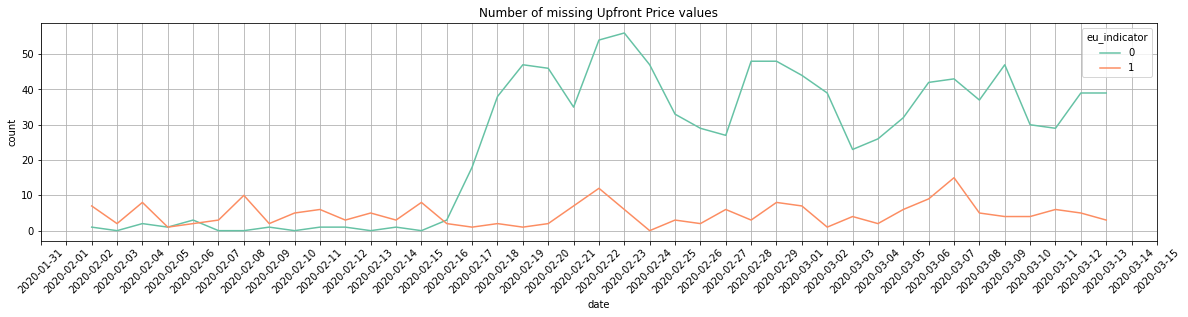

In [13]:
missing_values_agr = data.upfront_price.isnull().groupby([data["eu_indicator"],data["date"]]).sum().astype(int).reset_index(name="count")
fig=plt.figure(figsize=(20,4))
ax = sns.lineplot(data=missing_values_agr, x="date", y="count", hue="eu_indicator", palette="Set2")
plt.xticks(rotation=45)
plt.grid()
plt.title("Number of missing Upfront Price values")
loc = plticker.MultipleLocator(base=1.0)
ax.xaxis.set_major_locator(loc)
plt.show(ax)

In [14]:
a = sum(missing_values_agr[(missing_values_agr.eu_indicator==0) & (missing_values_agr.date>=dt.date(2020,2,17))]["count"])
print("Number of missing upfront_price values for non-EU rides starting from 2020-02-17: ", a)

Number of missing upfront_price values for non-EU rides starting from 2020-02-17:  996


**There is a remarkable increase in missing values for non-EU rides starting from 2020-02-17. This raises questions like:**
* **Has the current model stopped working for non-EU rides starting from 2020-02-17?**
* **Was there a new model implemented on 2020-02-17 and the ETL is malfunctioning?**

Note! Closer look reveals that the missing values in the datasetfor non-EU rides started to appear on 2020-02-17 at around 16:20:00. In addition prediction_price_type for these rides has changed from "upfront" to "prediction" which hints that a new model/logic might have been implemented.

Let's look at all the existing upfront_price values on a timeline to get more insights:

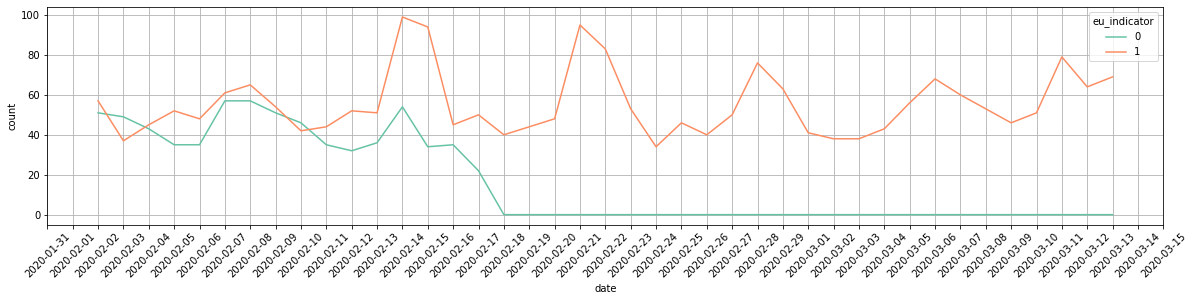

In [15]:
existing_values_agr = data.upfront_price.notnull().groupby([data["eu_indicator"],data["date"]]).sum().astype(int).reset_index(name="count")
fig=plt.figure(figsize=(20,4))
ax = sns.lineplot(data=existing_values_agr, x="date", y="count", hue="eu_indicator", palette="Set2")
plt.xticks(rotation=45)
plt.grid()
loc = plticker.MultipleLocator(base=1.0)
ax.xaxis.set_major_locator(loc)
plt.show(ax)

**It turns out that indeed there are no upfront_price values for non-EU rides starting from 2020-02-18 (and very few values on 2020-02-17) in the dataset.** This helps to explain 996 missing upfront_price values out from 1201. Let's take a closer look at the rest of the ~200 (14 for non-EU, 191 for EU) rides with missing upfront prices by looking at their top level statistics. 

**EU:**

In [16]:
data[data.upfront_price.isna() & data.eu_indicator==1].describe()

,order_id_new,order_try_id_new,metered_price,upfront_price,distance,duration,gps_confidence,dest_change_number,predicted_distance,predicted_duration,ticket_id_new,device_token,driver_device_uid_new,eu_indicator,overpaid_ride_ticket,fraud_score,hour
count,191.000000,191.000000,191.000000,0.0,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,0.0,191.000000,191.0,191.000000,141.000000,191.000000
mean,2217.094241,2217.094241,13.135969,NaN,15418.052356,1927.732984,0.785340,2.329843,10720.214660,987.329843,2306.518325,NaN,995.089005,1.0,0.015707,-549.312057,11.916230
std,1226.228802,1226.228802,12.668808,NaN,21392.758846,1870.120189,0.411665,1.261202,17904.271868,885.373035,1498.642747,NaN,603.346080,0.0,0.124665,782.548950,6.936805
min,2.000000,2.000000,2.380000,NaN,1.000000,374.000000,0.000000,1.000000,0.000000,0.000000,64.000000,NaN,13.000000,1.0,0.000000,-4568.000000,0.000000
25%,1088.500000,1088.500000,6.190000,NaN,5347.000000,871.500000,1.000000,2.000000,4135.000000,551.000000,912.500000,NaN,473.500000,1.0,0.000000,-660.000000,6.000000
50%,2267.000000,2267.000000,8.660000,NaN,9936.000000,1390.000000,1.000000,2.000000,7282.000000,830.000000,2243.000000,NaN,929.000000,1.0,0.000000,-268.000000,13.000000
75%,3356.500000,3356.500000,14.995000,NaN,16818.000000,2203.500000,1.000000,2.000000,12084.500000,1176.000000,3733.500000,NaN,1489.500000,1.0,0.000000,-58.000000,17.000000
max,4160.000000,4160.000000,103.900000,NaN,233190.000000,15618.000000,1.000000,12.000000,217444.000000,9893.000000,4848.000000,NaN,2119.000000,1.0,1.000000,1.000000,23.000000


In [17]:
data[data.eu_indicator==1].describe()

,order_id_new,order_try_id_new,metered_price,upfront_price,distance,duration,gps_confidence,dest_change_number,predicted_distance,predicted_duration,ticket_id_new,device_token,driver_device_uid_new,eu_indicator,overpaid_ride_ticket,fraud_score,hour
count,2465.000000,2465.000000,2465.000000,2274.000000,2465.000000,2465.000000,2465.000000,2465.000000,2465.000000,2465.000000,2465.000000,0.0,2465.000000,2465.0,2465.000000,1873.000000,2465.000000
mean,2139.202840,2139.199189,7.578974,6.496262,8861.803245,1040.495335,0.955781,1.161866,8024.549696,864.262069,2416.172414,NaN,1068.715619,1.0,0.004057,-677.311265,12.515213
std,1199.817715,1199.820032,6.957961,5.135782,10839.153418,917.460561,0.205623,0.611183,9462.821907,561.638070,1442.018245,NaN,640.343045,0.0,0.063577,1121.105752,6.619888
min,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,NaN,0.000000,1.0,0.000000,-14225.000000,0.000000
25%,1129.000000,1129.000000,4.000000,3.700000,3798.000000,535.000000,1.000000,1.000000,3609.000000,519.000000,1113.000000,NaN,512.000000,1.0,0.000000,-830.000000,7.000000
50%,2124.000000,2124.000000,5.880000,5.200000,6410.000000,842.000000,1.000000,1.000000,5931.000000,755.000000,2456.000000,NaN,1056.000000,1.0,0.000000,-280.000000,13.000000
75%,3188.000000,3188.000000,8.740000,7.600000,10662.000000,1270.000000,1.000000,1.000000,9605.000000,1066.000000,3660.000000,NaN,1619.000000,1.0,0.000000,-68.000000,18.000000
max,4165.000000,4165.000000,119.430000,93.800000,233190.000000,15618.000000,1.000000,12.000000,217444.000000,9893.000000,4938.000000,NaN,2158.000000,1.0,1.000000,49.000000,23.000000


**Significant findings for EU rides with missing upfront_price:**
* Low gps_confidence (mean 0,79)
* High dest_change_number (mean 2,33)
* High distance and duration values -> high metered_price values

In [18]:
a = data[data.upfront_price.isna() & data.eu_indicator==1].groupby(["gps_confidence","dest_change_number"]).size().reset_index(name='counts')
print(a)

    gps_confidence  dest_change_number  counts
0                0                   1      20
1                0                   2      10
2                0                   3       5
3                0                   4       3
4                0                   5       2
5                0                   9       1
6                1                   1       4
7                1                   2     114
8                1                   3      16
9                1                   4      10
10               1                   5       3
11               1                   6       2
12               1                  12       1


Most of the missing upfront_price values for EU rides can be explained with bad GPS connection or destination changes during the ride. Only 4 remain mysterious (high GPS connection and no destination changes). But with the current task at hand to further analyse the reasons is unnecessasry.

**non-EU:**

In [19]:
data[(data.eu_indicator==0) & (data.date<dt.date(2020,2,17))].describe()

,order_id_new,order_try_id_new,metered_price,upfront_price,distance,duration,gps_confidence,dest_change_number,predicted_distance,predicted_duration,ticket_id_new,device_token,driver_device_uid_new,eu_indicator,overpaid_ride_ticket,fraud_score,hour
count,664.000000,664.000000,664.000000,650.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,0.0,664.00000,664.0,664.000000,14.000000,664.000000
mean,743.451807,743.460843,18852.184593,16548.461538,11028.094880,2031.201807,0.659639,1.090361,10723.138554,1475.016566,2236.603916,NaN,1121.99247,0.0,0.111446,-1276.857143,13.344880
std,450.420726,450.420258,21530.692419,34689.481527,11963.957567,2013.584798,0.474188,0.352920,18551.157514,1311.277928,591.271670,NaN,590.96417,0.0,0.314921,1373.701505,5.823967
min,9.000000,9.000000,2000.000000,2000.000000,0.000000,0.000000,0.000000,1.000000,577.000000,113.000000,131.000000,NaN,12.00000,0.0,0.000000,-4664.000000,0.000000
25%,352.750000,352.750000,6000.000000,7000.000000,3378.500000,753.500000,0.000000,1.000000,5182.750000,853.750000,1769.750000,NaN,614.00000,0.0,0.000000,-1960.000000,9.000000
50%,717.500000,717.500000,11619.695000,11000.000000,8064.500000,1495.000000,1.000000,1.000000,8184.000000,1263.000000,2195.000000,NaN,1106.50000,0.0,0.000000,-793.500000,14.000000
75%,1105.250000,1105.250000,21333.935000,16500.000000,14663.250000,2771.000000,1.000000,1.000000,12172.500000,1805.750000,2657.500000,NaN,1627.75000,0.0,0.000000,-169.250000,18.000000
max,1585.000000,1585.000000,194483.520000,595000.000000,123934.000000,18734.000000,1.000000,4.000000,353538.000000,20992.000000,4896.000000,NaN,2156.00000,0.0,1.000000,30.000000,23.000000


In [20]:
data[(data.upfront_price.isna()) & (data.eu_indicator==0) & (data.date<dt.date(2020,2,17))].describe()

,order_id_new,order_try_id_new,metered_price,upfront_price,distance,duration,gps_confidence,dest_change_number,predicted_distance,predicted_duration,ticket_id_new,device_token,driver_device_uid_new,eu_indicator,overpaid_ride_ticket,fraud_score,hour
count,14.000000,14.000000,14.000000,0.0,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,0.0,14.000000,14.0,14.000000,0.0,14.000000
mean,781.285714,781.285714,26408.352857,NaN,16460.642857,2552.928571,0.214286,2.071429,7235.357143,1084.714286,2256.142857,NaN,1177.857143,0.0,0.214286,NaN,12.428571
std,530.945663,530.945663,20224.842628,NaN,14044.856582,1523.617228,0.425815,0.474631,4636.684270,719.254895,583.968236,NaN,559.250303,0.0,0.425815,NaN,6.722114
min,115.000000,115.000000,6000.000000,NaN,1908.000000,536.000000,0.000000,1.000000,1484.000000,348.000000,1537.000000,NaN,358.000000,0.0,0.000000,NaN,0.000000
25%,339.250000,339.250000,11352.627500,NaN,5329.750000,1427.000000,0.000000,2.000000,3632.000000,627.500000,1802.500000,NaN,751.500000,0.0,0.000000,NaN,7.500000
50%,600.000000,600.000000,18899.160000,NaN,10731.500000,2222.000000,0.000000,2.000000,6932.000000,927.500000,2047.000000,NaN,1089.000000,0.0,0.000000,NaN,11.500000
75%,1184.250000,1184.250000,31953.825000,NaN,21613.750000,3715.250000,0.000000,2.000000,10305.000000,1349.750000,2707.000000,NaN,1505.500000,0.0,0.000000,NaN,18.000000
max,1565.000000,1565.000000,72871.720000,NaN,49748.000000,5292.000000,1.000000,3.000000,17784.000000,3125.000000,3137.000000,NaN,2122.000000,0.0,1.000000,NaN,22.000000


**Significant findings for non-EU rides with missing upfront_price:**
* Low gps_confidence (mean 0,21)
* High dest_change_number (mean 2,07)

In [21]:
a = data[(data.upfront_price.isna()) & (data.eu_indicator==0) & (data.date<dt.date(2020,2,17))].groupby(["gps_confidence","dest_change_number"]).size().reset_index(name='counts')
print(a)

   gps_confidence  dest_change_number  counts
0               0                   1       1
1               0                   2       8
2               0                   3       2
3               1                   2       3


All the missing upfront_price values for non-EU rides before 2020-02-17 can be explained with either bad GPS connection or destination changes during the ride.

<a id="id1"></a>
### 1.4 EU vs non-EU data

We already noticed that there is a huge difference in EU vs non-EU price variables. Hence we can assume we are dealing with different currencies. 

**Let's take a closer look at ride prices in EU and non-EU**

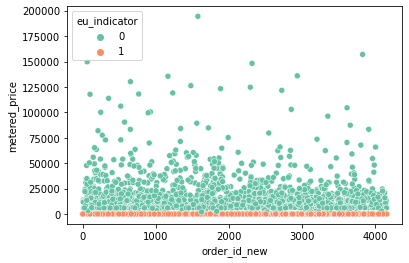

In [22]:
ax = sns.scatterplot(data=data, x="order_id_new", y="metered_price", hue="eu_indicator", palette="Set2")

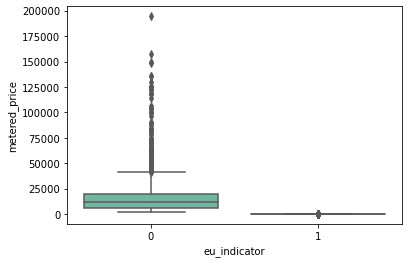

In [23]:
ax = sns.boxplot(data=data, x="eu_indicator", y="metered_price", palette="Set2")

**Based on the charts we can be certain that there is a difference in currencies between EU and non-EU rides. Let's investigate further whether there are any other differences in the data between EU and non-EU rides.**

**EU:**

In [24]:
data_eu = data[data.eu_indicator==1]
data_eu.describe()

,order_id_new,order_try_id_new,metered_price,upfront_price,distance,duration,gps_confidence,dest_change_number,predicted_distance,predicted_duration,ticket_id_new,device_token,driver_device_uid_new,eu_indicator,overpaid_ride_ticket,fraud_score,hour
count,2465.000000,2465.000000,2465.000000,2274.000000,2465.000000,2465.000000,2465.000000,2465.000000,2465.000000,2465.000000,2465.000000,0.0,2465.000000,2465.0,2465.000000,1873.000000,2465.000000
mean,2139.202840,2139.199189,7.578974,6.496262,8861.803245,1040.495335,0.955781,1.161866,8024.549696,864.262069,2416.172414,NaN,1068.715619,1.0,0.004057,-677.311265,12.515213
std,1199.817715,1199.820032,6.957961,5.135782,10839.153418,917.460561,0.205623,0.611183,9462.821907,561.638070,1442.018245,NaN,640.343045,0.0,0.063577,1121.105752,6.619888
min,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,NaN,0.000000,1.0,0.000000,-14225.000000,0.000000
25%,1129.000000,1129.000000,4.000000,3.700000,3798.000000,535.000000,1.000000,1.000000,3609.000000,519.000000,1113.000000,NaN,512.000000,1.0,0.000000,-830.000000,7.000000
50%,2124.000000,2124.000000,5.880000,5.200000,6410.000000,842.000000,1.000000,1.000000,5931.000000,755.000000,2456.000000,NaN,1056.000000,1.0,0.000000,-280.000000,13.000000
75%,3188.000000,3188.000000,8.740000,7.600000,10662.000000,1270.000000,1.000000,1.000000,9605.000000,1066.000000,3660.000000,NaN,1619.000000,1.0,0.000000,-68.000000,18.000000
max,4165.000000,4165.000000,119.430000,93.800000,233190.000000,15618.000000,1.000000,12.000000,217444.000000,9893.000000,4938.000000,NaN,2158.000000,1.0,1.000000,49.000000,23.000000


**non-EU:**

In [25]:
data_non_eu = data[data.eu_indicator==0]
data_non_eu.describe()

,order_id_new,order_try_id_new,metered_price,upfront_price,distance,duration,gps_confidence,dest_change_number,predicted_distance,predicted_duration,ticket_id_new,device_token,driver_device_uid_new,eu_indicator,overpaid_ride_ticket,fraud_score,hour
count,1682.000000,1682.000000,1682.000000,672.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,0.0,1682.000000,1682.0,1682.000000,53.000000,1682.000000
mean,2002.841260,2002.846611,17294.734893,16334.077381,10410.241379,2148.800238,0.612961,1.067776,9833.901308,1401.732461,2514.814507,NaN,1139.543401,0.0,0.148038,-739.943396,13.321046
std,1202.197647,1202.194864,18464.655207,34166.872636,10625.467923,2063.777069,0.487218,0.316391,13068.427841,1004.332823,1412.024795,NaN,593.809532,0.0,0.355243,1002.141503,5.687512
min,9.000000,9.000000,2000.000000,2000.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000,NaN,1.000000,0.0,0.000000,-4664.000000,0.000000
25%,914.000000,914.000000,6000.000000,7000.000000,3575.500000,815.250000,0.000000,1.000000,5122.000000,856.250000,1369.750000,NaN,638.250000,0.0,0.000000,-1222.000000,9.000000
50%,1961.500000,1961.500000,12142.590000,11000.000000,7989.000000,1677.000000,1.000000,1.000000,8080.000000,1253.500000,2453.500000,NaN,1135.000000,0.0,0.000000,-226.000000,14.000000
75%,3016.250000,3016.250000,20084.580000,16500.000000,13203.250000,2871.750000,1.000000,1.000000,11340.000000,1764.000000,3764.250000,NaN,1666.000000,0.0,0.000000,0.000000,18.000000
max,4159.000000,4159.000000,194483.520000,595000.000000,123934.000000,22402.000000,1.000000,5.000000,353538.000000,20992.000000,4941.000000,NaN,2156.000000,0.0,1.000000,32.000000,23.000000


**Additional differences in data between EU and non-EU rides that stand out (numeric values):**
* Actual ride durations (mean):
    * EU = 1041
    * non-EU = 2148
* GPS confidence (mean):
    * EU = 0,96
    * non-EU = 0,61
* Number of destination changes (mean):
    * EU = 1,16
    * non-EU = 1,07
* Overpaid ride complaints (mean):
    * EU = 0,0041
    * non-EU = 0,1480

Note! At this point we cannot be certain that for all non-EU rides a common currency is used as the metered_price for non-EU rides range from 2k to 194k units. We actually cannot even be sure whether a common currency is used for all the EU rides. For the purpose of this hometask let's assume that there are two different currencies represented in the dataset, one for EU and one for non-EU. In reality this of course should be confirmed as it can have an impact on the results of the analysis.

**Let's also take a look at different non-numeric variables:**

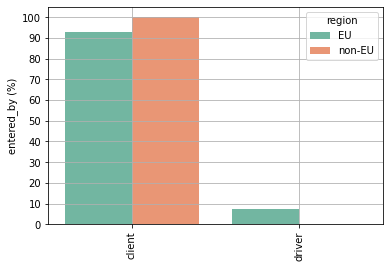

In [26]:
eu_df = pd.DataFrame(data_eu['entered_by'].value_counts(normalize=True) * 100)
eu_df["region"] = "EU"
non_eu_df = pd.DataFrame(data_non_eu['entered_by'].value_counts(normalize=True) * 100)
non_eu_df["region"]= "non-EU"
combined = eu_df.append(non_eu_df)
ax = sns.barplot(data=combined, x=combined.index, y="entered_by", hue="region", palette="Set2")
plt.grid()
loc = plticker.MultipleLocator(base=10.0)
ax.yaxis.set_major_locator(loc)
plt.ylabel("entered_by (%)")
plt.xticks(rotation=90)
plt.show(ax)

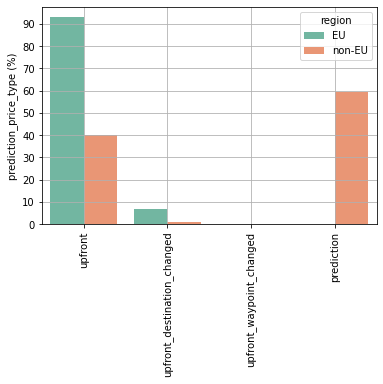

In [27]:
eu_df = pd.DataFrame(data_eu['prediction_price_type'].value_counts(normalize=True) * 100)
eu_df["region"] = "EU"
non_eu_df = pd.DataFrame(data_non_eu['prediction_price_type'].value_counts(normalize=True) * 100)
non_eu_df["region"]= "non-EU"
combined = eu_df.append(non_eu_df)
ax = sns.barplot(data=combined, x=combined.index, y="prediction_price_type", hue="region", palette="Set2")
plt.grid()
loc = plticker.MultipleLocator(base=10.0)
ax.yaxis.set_major_locator(loc)
plt.ylabel("prediction_price_type (%)")
plt.xticks(rotation=90)
plt.show(ax)

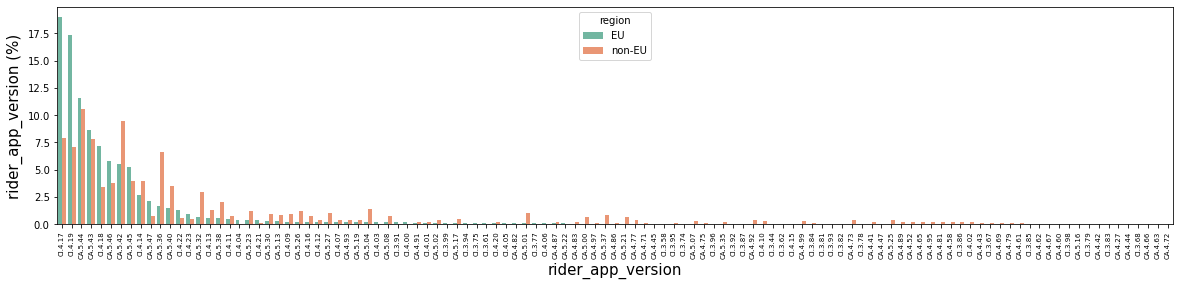

In [28]:
eu_df = pd.DataFrame(data_eu['rider_app_version'].value_counts(normalize=True) * 100)
eu_df["region"] = "EU"
non_eu_df = pd.DataFrame(data_non_eu['rider_app_version'].value_counts(normalize=True) * 100)
non_eu_df["region"]= "non-EU"
combined = eu_df.append(non_eu_df)
fig=plt.figure(figsize=(20,4))
ax = sns.barplot(data=combined, x=combined.index, y="rider_app_version", hue="region", palette="Set2")
plt.ylabel("rider_app_version (%)",fontsize=15)
plt.xticks(rotation=90, fontsize=7)
ax.set_xlabel("rider_app_version", fontsize=15)
plt.show(ax)

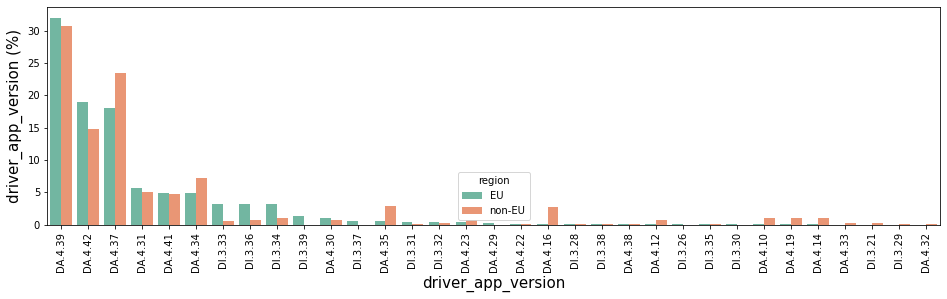

In [29]:
eu_df = pd.DataFrame(data_eu['driver_app_version'].value_counts(normalize=True) * 100)
eu_df["region"] = "EU"
non_eu_df = pd.DataFrame(data_non_eu['driver_app_version'].value_counts(normalize=True) * 100)
non_eu_df["region"]= "non-EU"
combined = eu_df.append(non_eu_df)
fig=plt.figure(figsize=(16,4))
ax = sns.barplot(data=combined, x=combined.index, y="driver_app_version", hue="region", palette="Set2")
plt.ylabel("driver_app_version (%)",fontsize=15)
plt.xticks(rotation=90)
ax.set_xlabel("driver_app_version", fontsize=15)
plt.show(ax)

**Additional differences in data between EU and non-EU rides that stand out (non-numeric values):**
* In EU sometimes the driver inputs the destination (approx 7% of times). In non-EU it's always the rider.
* Prediction types used for price predictions differ a lot between EU and non-EU rides. For EU the prediction_price_type is mostly *upfront* or *upfront_destination_changed*. For non-EU it's *upfront* until 2020-02-17 and *prediction* starting from 2020-02-17 16:20:00 (occasionally also *upfront_destination_changed*)
* In EU handful of different rider app versions are used by high percentage of the all riders. In non-EU the variation between app versions used by riders is more diverse.

**Due to all these differences in data between EU and non-EU rides it makes sense to build different prediction models for EU and non-EU.**

Note! Although by simply looking at the dataset at hand we cannot be certain that seperate models have been built for EU and non-EU rides currently, there are multiple hints in the dataset that support this idea.

## 2. Building new prediction models

### 2.1 Quick look at the current state

Let's evaluate the current state of precision based on the dataset we have. As we will approach predicting prices for EU and non-EU regions seperately we should evaluate current precision from that angle as well.

In [30]:
data_eu_ok = data_eu[data_eu.upfront_price.notnull()].reset_index(drop=True)
data_non_eu_ok = data_non_eu[data_non_eu.upfront_price.notnull()].reset_index(drop=True)

# Mean Absolute Error (MAE)
print("EU MAE: ", metrics.mean_absolute_error(data_eu_ok.metered_price, data_eu_ok.upfront_price))
print("non-EU MAE: ", metrics.mean_absolute_error(data_non_eu_ok.metered_price, data_non_eu_ok.upfront_price))

# Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("EU MAPE: ", mean_absolute_percentage_error(data_eu_ok.metered_price,data_eu_ok.upfront_price))
print("non-EU MAPE: ", mean_absolute_percentage_error(data_non_eu_ok.metered_price,data_non_eu_ok.upfront_price))

# R sqaured
print("EU R-squared: ", metrics.r2_score(data_eu_ok.metered_price, data_eu_ok.upfront_price))
print("non-EU R-squared: ", metrics.r2_score(data_non_eu_ok.metered_price, data_non_eu_ok.upfront_price))

EU MAE:  1.3634828496042217
non-EU MAE:  10480.045639880953
EU MAPE:  21.46482168850514
non-EU MAPE:  61.45624078596763
EU R-squared:  0.7901730610025165
non-EU R-squared:  -1.8556523481581575


Looking at these values (MAE, MAPE, R-squared) we can say that the EU predictions are not too far off however non-EU prediction are very off.

Although current EU price prediction aren't too bad, on average the upfront price prediction is not used to charge the customer, because MAPE value (21,5%) for EU rides is >20% (in case where uopfront price prediction differs by more than 20% the metered price is used when charging the customer). 

Let's try to evaluate to what extent does this affect customer satisfaction by looking at the number of overpaid ride complaints from the customers.

In [31]:
# Let's exclude rides with destination changes and look at predictions results based on more "simple" rides

data_eu_ok_single = data_eu[(data_eu.upfront_price.notnull()) & (data_eu.dest_change_number ==1)].reset_index(drop=True)
data_non_eu_ok_single = data_non_eu[(data_non_eu.upfront_price.notnull()) & (data_non_eu.dest_change_number ==1)].reset_index(drop=True)

# Mean Absolute Error (MAE)
print("EU MAE: ", metrics.mean_absolute_error(data_eu_ok_single.metered_price, data_eu_ok_single.upfront_price))
print("non-EU MAE: ", metrics.mean_absolute_error(data_non_eu_ok_single.metered_price, data_non_eu_ok_single.upfront_price))

# Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("EU MAPE: ", mean_absolute_percentage_error(data_eu_ok_single.metered_price,data_eu_ok_single.upfront_price))
print("non-EU MAPE: ", mean_absolute_percentage_error(data_non_eu_ok_single.metered_price,data_non_eu_ok_single.upfront_price))

# R sqaured
print("EU R-squared: ", metrics.r2_score(data_eu_ok_single.metered_price, data_eu_ok_single.upfront_price))
print("non-EU R-squared: ", metrics.r2_score(data_non_eu_ok_single.metered_price, data_non_eu_ok_single.upfront_price))


EU MAE:  1.3092584167424932
non-EU MAE:  9072.44863422292
EU MAPE:  21.32825253450477
non-EU MAPE:  49.88106082810749
EU R-squared:  0.7943929684259108
non-EU R-squared:  -0.8052974843883205


In [32]:
# Add a binarty variable indicating whether the metered_price was used in the end to charge the customer
# 0 = upfront_price used
# 1 = metered_price used
data["mp_indicator"] = 0
data["pred_diff_pct"] = abs((data.metered_price - data.upfront_price) / data.metered_price)
data["mp_indicator"] = np.where((data["pred_diff_pct"] > 0.2) | (data["upfront_price"].isnull()), 1, data["mp_indicator"])

# Only look at the rides where we have values for upfront_price
a = data[data.upfront_price.notna()].groupby(["eu_indicator","mp_indicator","overpaid_ride_ticket"]).size().reset_index(name='counts')
#a["share_of_complaints"] = a.counts / sum()
print(a)

# EU - upfront price used - 0 complaints 
# EU - metered price used - 7 complaints
print(7 / sum(a.counts[(a.eu_indicator==1) & (a.mp_indicator==1)])*100)

# non-EU - upfront price used - 22 complaints 
print(22 / sum(a.counts[(a.eu_indicator==0) & (a.mp_indicator==0)])*100)

# non-EU - metered price used - 50 complaints
print(50 / sum(a.counts[(a.eu_indicator==0) & (a.mp_indicator==1)])*100)


   eu_indicator  mp_indicator  overpaid_ride_ticket  counts
0             0             0                     0     274
1             0             0                     1      22
2             0             1                     0     326
3             0             1                     1      50
4             1             0                     0    1494
5             1             1                     0     773
6             1             1                     1       7
0.8974358974358974
7.4324324324324325
13.297872340425531


**Findings:**
* In EU there have been no complaints for overpaid rides when upfront price was used for charging
* In non-EU there is approx 2x higher probability of getting a customer complaint for overpaid rides when the metered price is used

**Hence by increasing the precision of current prediction models we would also significantly reduce the amount of customer complaints for overpaid rides. This means increased satisfaction for customers and less work for our customer service.**

Let's start by visualising current metered price vs upfront price predictions

**EU:**

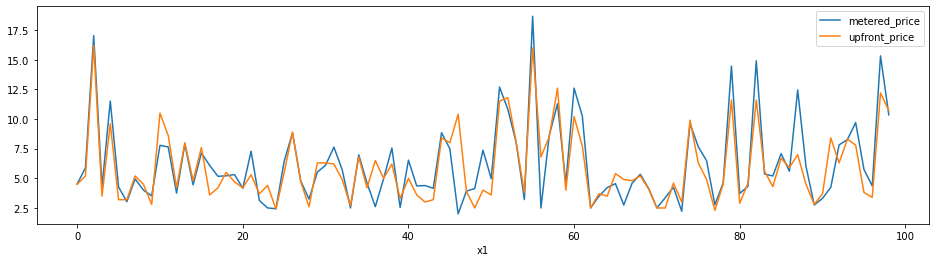

In [33]:
df1 = data_eu_ok[["order_id_new","metered_price","upfront_price"]][1:100].sort_values(by=['order_id_new']).reset_index(drop=True)
df1['x1'] = df1.index
fig=plt.figure(figsize=(16,4))
ax = plt.gca()
df1.plot(kind="line",x="x1",y="metered_price",ax=ax)
df1.plot(kind="line",x="x1",y="upfront_price",ax=ax)
plt.show()

<a id="id2"></a>

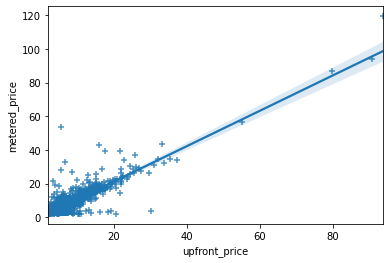

In [34]:
ax = sns.regplot(data=data_eu_ok, x="upfront_price", y="metered_price", marker="+")

**non-EU**

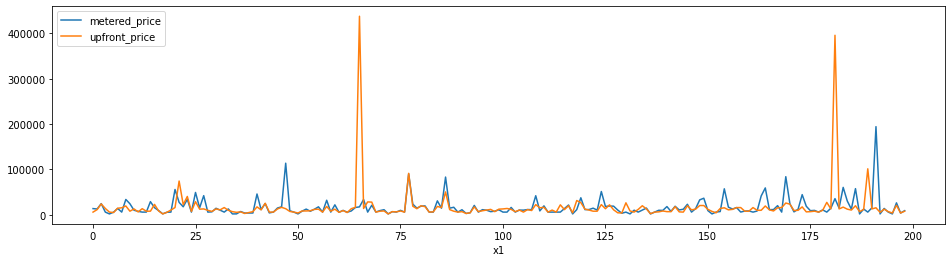

In [35]:
df1 = data_non_eu_ok[["order_id_new","metered_price","upfront_price"]][1:200].sort_values(by=['order_id_new']).reset_index(drop=True)
df1['x1'] = df1.index
fig=plt.figure(figsize=(16,4))
ax = plt.gca()
df1.plot(kind="line",x="x1",y="metered_price",ax=ax)
df1.plot(kind="line",x="x1",y="upfront_price",ax=ax)
plt.show()

<a id="id3"></a>

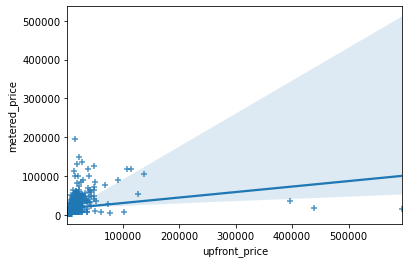

In [36]:
ax = sns.regplot(data=data_non_eu_ok, x="upfront_price", y="metered_price", marker="+")

**It seems that the current model for EU is not performing so well when it comes to cheaper rides ([price < 20](#id2)). There is lots of variation in metered_price with low upfront_price rides.
In case of non-EU the precision is of course even worse and in addition we can see that in some cases the model returns absurd upfront prices (very high upfront_price values - in the bottom left corner of the [non-EU price chart](#id3)**

Time to move on to building better upfront price prediction models...

### 2.2 Closer data exploration and feature engineering

Start by getting more out from our timestamp variable. We already created hour variables but let's create couple of more that might turn out to be useful

In [37]:
# Day of week
data["weekday"] = data.calc_created.dt.weekday

# Weekend indicator
data["weekend_indicator"] = np.where((data.weekday < 5), 0, 1)

# Skipping holidays

# Part of day
b = [0,4,8,12,16,20,24]
l = ['Late Night', 'Early Morning','Morning','Noon','Eve','Night']
data['part_of_day'] = pd.cut(data['hour'], bins=b, labels=l, include_lowest=True)
data.head(10)

,order_id_new,order_try_id_new,calc_created,metered_price,upfront_price,distance,duration,gps_confidence,entered_by,b_state,dest_change_number,prediction_price_type,predicted_distance,predicted_duration,change_reason_pricing,ticket_id_new,device_token,rider_app_version,order_state,order_try_state,driver_app_version,driver_device_uid_new,device_name,eu_indicator,overpaid_ride_ticket,fraud_score,date,hour,mp_indicator,pred_diff_pct,weekday,weekend_indicator,part_of_day
0,22,22,2020-02-02 03:37:31,4.04,10.0,2839,700,1,client,finished,1,upfront,13384.0,1091.0,NaN,1376,NaN,CI.4.17,finished,finished,DA.4.37,1596,Xiaomi Redmi 6,1,0,-1383.0,2020-02-02,3,1,1.475248,6,1,Late Night
1,618,618,2020-02-08 02:26:19,6.09,3.6,5698,493,1,client,finished,1,upfront,2286.0,360.0,NaN,2035,NaN,CA.5.43,finished,finished,DA.4.39,1578,Samsung SM-G965F,1,0,NaN,2020-02-08,2,1,0.408867,5,1,Late Night
2,313,313,2020-02-05 06:34:54,72871.72,NaN,49748,1400,0,client,finished,2,upfront_destination_changed,3017.0,600.0,client_destination_changed,1788,NaN,CA.5.23,finished,finished,DA.4.37,1587,TECNO-Y6,0,1,NaN,2020-02-05,6,1,NaN,2,0,Early Morning
3,1176,1176,2020-02-13 17:31:24,20032.50,19500.0,10273,5067,1,client,finished,1,upfront,14236.0,2778.0,NaN,2710,NaN,CA.5.04,finished,finished,DA.4.37,433,Itel W5504,0,0,NaN,2020-02-13,17,0,0.026582,3,0,Eve
4,1209,1209,2020-02-14 01:27:01,6.11,6.3,4924,513,1,client,finished,1,upfront,4882.0,562.0,NaN,2732,NaN,CA.5.04,finished,finished,DA.4.39,1591,HUAWEI WAS-LX1,1,0,NaN,2020-02-14,1,0,0.031097,4,0,Late Night
5,1662,1662,2020-02-17 18:24:45,2.61,6.5,2020,412,1,client,finished,1,upfront,8545.0,888.0,NaN,3229,NaN,CI.4.18,finished,finished,DA.4.37,1701,Samsung SM-N950F,1,0,-2350.0,2020-02-17,18,1,1.490421,0,0,Eve
6,1999,1999,2020-02-21 11:02:38,4.14,2.5,3845,720,1,client,finished,1,upfront,1883.0,298.0,NaN,3631,NaN,CI.4.18,finished,finished,DA.4.39,1960,Samsung SM-G930F,1,0,-5181.0,2020-02-21,11,1,0.396135,4,0,Morning
7,2366,2366,2020-02-24 08:51:31,8.04,8.1,9977,1257,1,client,finished,1,upfront,9891.0,1282.0,NaN,4157,NaN,CA.5.44,finished,finished,DA.4.39,1339,HUAWEI BLA-L29,1,0,-652.0,2020-02-24,8,0,0.007463,0,0,Early Morning
8,2803,2803,2020-02-29 01:44:16,18.80,NaN,17107,1552,1,client,finished,2,upfront_destination_changed,11054.0,962.0,client_destination_changed,4608,NaN,CI.4.17,finished,finished,DA.4.37,1695,LENOVO Lenovo TB-7304F,1,0,-100.0,2020-02-29,1,1,NaN,5,1,Late Night
9,3299,3299,2020-03-05 18:52:48,7.65,6.3,13355,1335,1,client,finished,1,upfront,11823.0,888.0,NaN,282,NaN,CA.5.32,finished,finished,DI.3.37,214,"iPhone9,3",1,0,-44.0,2020-03-05,18,0,0.176471,3,0,Eve


To make our life easier let's create another dataset that only contains the useful data accessible during the time of prediction (when the customer is ordering the ride) and let's replace some of the missing values

In [38]:
#data = data_original

In [39]:
data_original = data.copy()
data = data.drop(columns=["order_id_new", "distance", "duration", "upfront_price", "b_state", "ticket_id_new", "device_token", "pred_diff_pct", "mp_indicator","overpaid_ride_ticket"])
data.fraud_score = data.fraud_score.fillna(0)
data_eu = data[data.eu_indicator==1]
data_eu = data_eu.drop(columns=["eu_indicator"])
data_non_eu = data[data.eu_indicator==0]
data_non_eu = data_non_eu.drop(columns=["eu_indicator"]) 

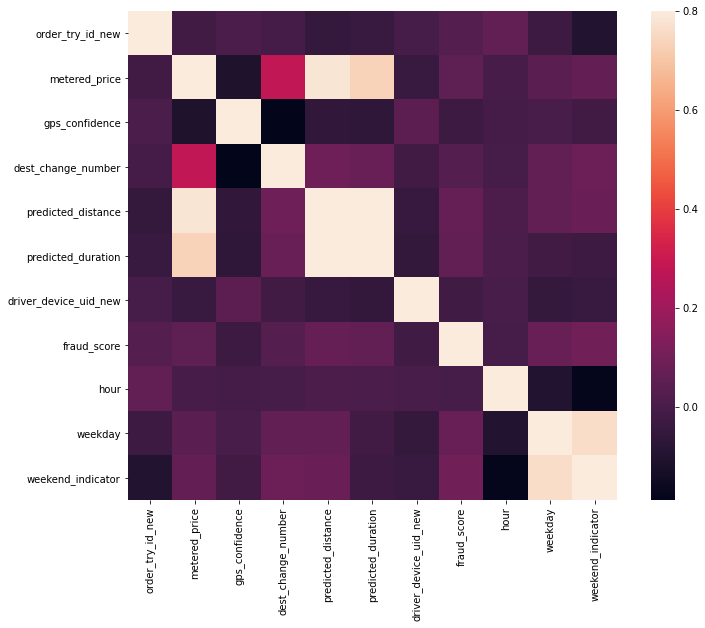

In [40]:
#correlation matrix for EU rides
corrmat = data_eu.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In case of EU rides we can clearly see from the heatmap that:
* predicted distance and price are strongly correlated to metered_price - *that's good*
* strong correlation between upfront_price and metered_price - *because the current model for EU is doing somewhat decent job*
* GPS confidence is showing negative correlation to metered_price
* Destination changes are positevely correlated to metered_price - *which makes sense as the changes will most likely increase the distance however we don't know when the changes in the route are actually done (before the ride or during the ride) - therefor let's leave this variable out from the scope at the moment*

To get closer to what we are after, let's look specifically at metered_price corralations:

In [41]:
# drop rides where dest_change_number > 1 from the dataset and then the variable itself
data_eu = data_eu[data_eu.dest_change_number == 1]
data_eu = data_eu.drop(columns=["dest_change_number"])
data_non_eu = data_non_eu[data_non_eu.dest_change_number == 1]
data_non_eu = data_non_eu.drop(columns=["dest_change_number"])

In [42]:
#data_eu

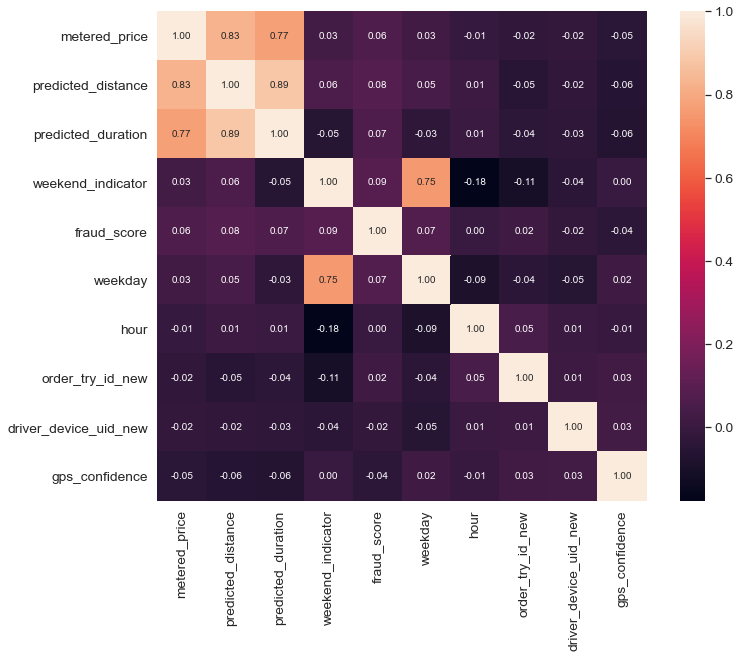

In [43]:
# Correlation matrix for EU metered_price
k = 20
cols = corrmat.nlargest(k, "metered_price")["metered_price"].index
cols = cols.drop("dest_change_number", errors='raise')
cm = np.corrcoef(data_eu[cols].values.T)
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(12, 9))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

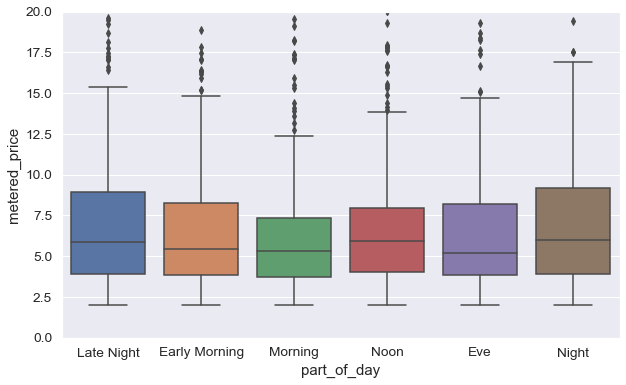

In [44]:
# metered_price vs time_of_day
var = "part_of_day"
data1 = pd.concat([data_eu["metered_price"], data_eu[var]], axis=1)
f, ax = plt.subplots(figsize=(10, 6))
fig = sns.boxplot(x=var, y="metered_price", data=data1)
fig.axis(ymin=0, ymax=20);

In EU rides done during late hours are more expensive (either due to longer distance or longer durations as to our knowledge these are the only variables making up the metered_price value). Rides done during morning hours seems to be the cheapest ones.

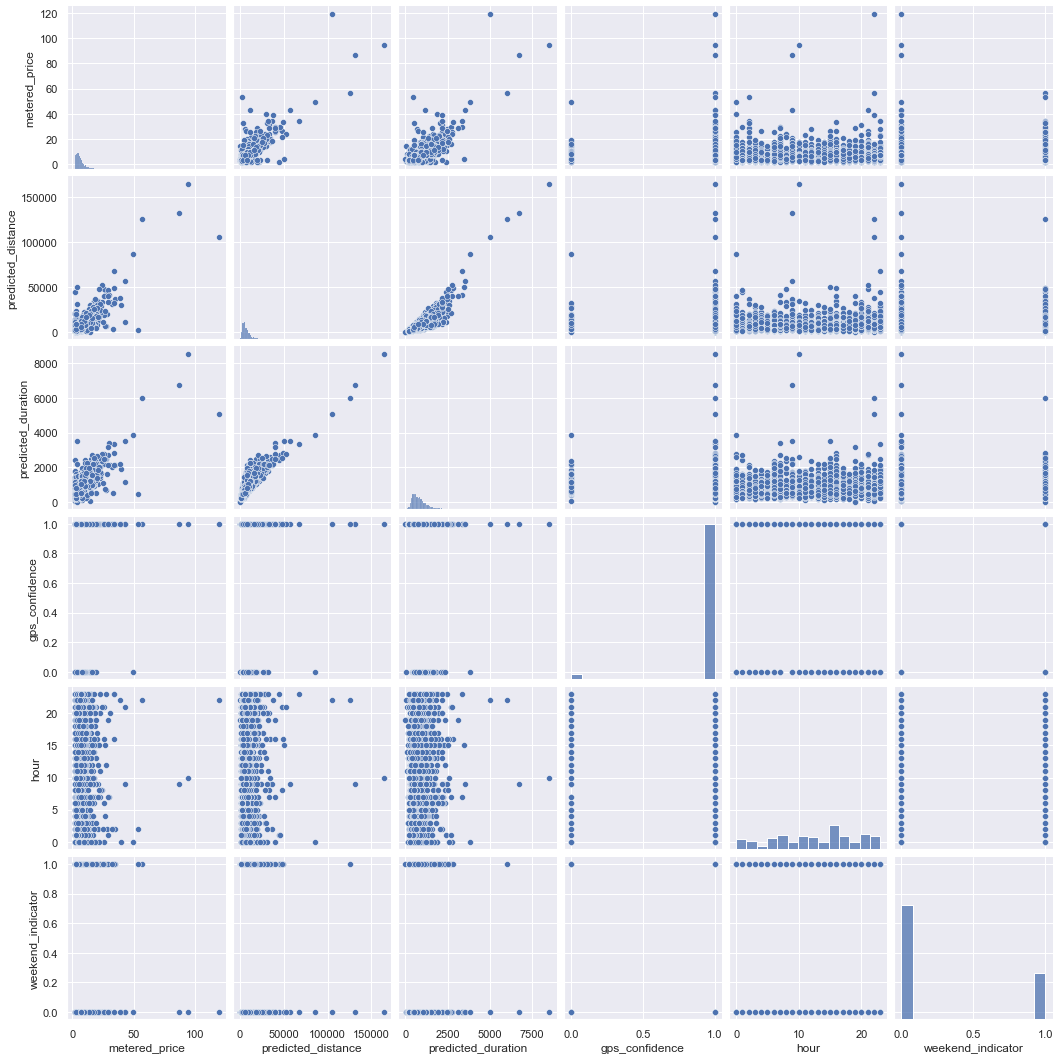

In [45]:
sns.set()
cols = ["metered_price","predicted_distance","predicted_duration","gps_confidence","hour", "weekend_indicator"]
sns.pairplot(data_eu[cols], height = 2.5)
plt.show()

**Let's move on to non-EU rides**

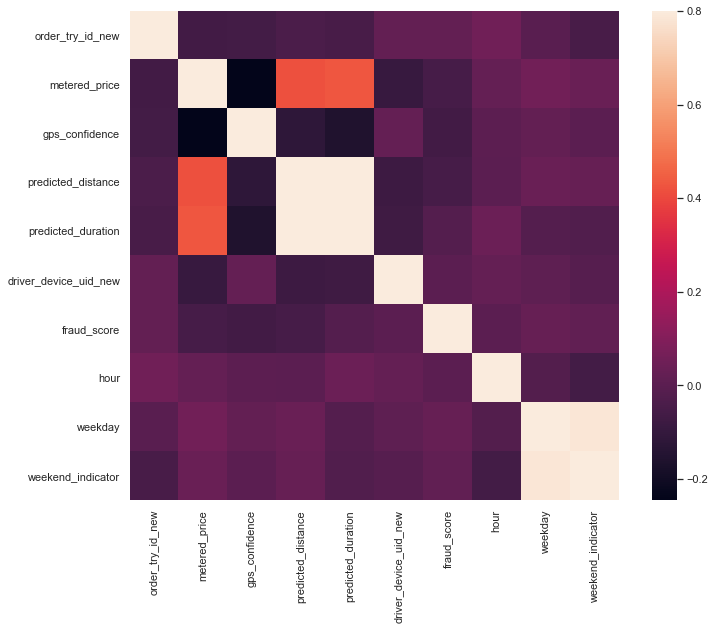

In [46]:
#correlation matrix for non-EU rides
corrmat = data_non_eu.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

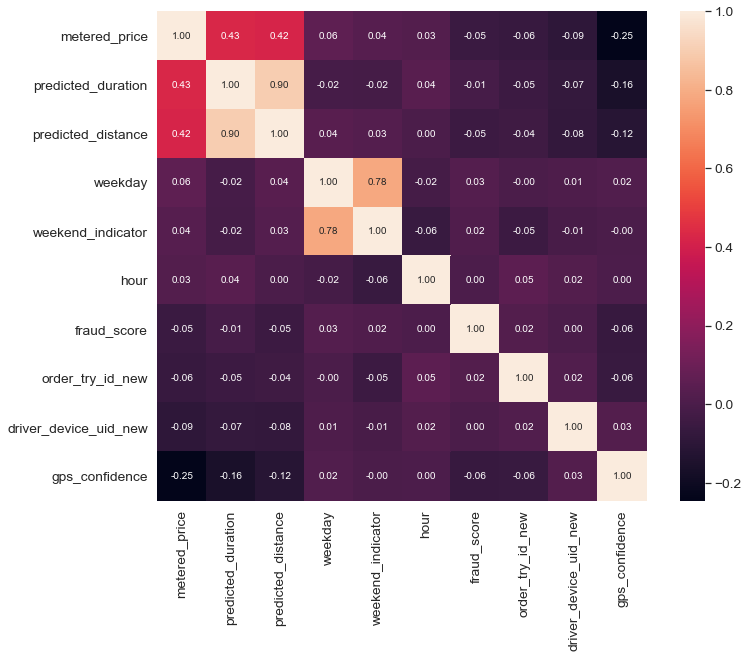

In [47]:
# Correlation matrix for non-EU metered_price
k = 20
cols = corrmat.nlargest(k, "metered_price")["metered_price"].index
cm = np.corrcoef(data_non_eu[cols].values.T)
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(12, 9))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In case of non-EU rides we can clearly see from the heatmap that:
* predicted distance and price are rather poorly correlated to metered_price - *that's bad and raises the question: How far are predicted distance and price from actuals for non-EU rides?*
* GPS confidence is showing stronger negative correlation to metered_price compared to EU rides

In [48]:
data_non_eu_ok

,order_id_new,order_try_id_new,calc_created,metered_price,upfront_price,distance,duration,gps_confidence,entered_by,b_state,dest_change_number,prediction_price_type,predicted_distance,predicted_duration,change_reason_pricing,ticket_id_new,device_token,rider_app_version,order_state,order_try_state,driver_app_version,driver_device_uid_new,device_name,eu_indicator,overpaid_ride_ticket,fraud_score,date,hour
0,1176,1176,2020-02-13 17:31:24,20032.50,19500.0,10273,5067,1,client,finished,1,upfront,14236.0,2778.0,NaN,2710,NaN,CA.5.04,finished,finished,DA.4.37,433,Itel W5504,0,0,NaN,2020-02-13,17
1,556,556,2020-02-07 18:30:00,6950.59,7000.0,2724,1293,1,client,finished,1,upfront,3634.0,804.0,NaN,1992,NaN,CI.4.14,finished,finished,DA.4.37,668,TECNO K7,0,0,NaN,2020-02-07,18
2,463,463,2020-02-06 20:06:40,5765.00,5000.0,9015,1206,1,client,finished,1,upfront,7875.0,1067.0,NaN,2335,NaN,CA.5.42,finished,finished,DA.4.35,1517,Itel S12,0,0,NaN,2020-02-06,20
3,1557,1557,2020-02-16 16:30:15,2000.00,7000.0,400,134,1,client,finished,1,upfront,10793.0,1462.0,NaN,3105,NaN,CA.4.89,finished,finished,DA.4.35,2084,Itel W5504,0,0,NaN,2020-02-16,16
4,40,40,2020-02-02 08:20:51,2000.00,6000.0,809,135,1,client,finished,1,upfront,8776.0,1556.0,NaN,1385,NaN,CA.5.42,finished,finished,DA.4.35,873,Itel S12,0,0,NaN,2020-02-02,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,377,377,2020-02-05 18:21:03,6000.00,6000.0,2920,641,1,client,finished,1,upfront,3047.0,564.0,NaN,1790,NaN,CA.5.07,finished,finished,DA.4.37,1255,TECNO MOBILE LIMITED TECNO KB8,0,0,NaN,2020-02-05,18
668,1516,1516,2020-02-16 02:20:50,9407.28,9500.0,7133,813,1,client,finished,1,upfront,7043.0,866.0,NaN,3038,NaN,CA.4.83,finished,finished,DA.4.39,1403,TECNO MOBILE LIMITED TECNO KA7,0,1,NaN,2020-02-16,2
669,1629,1629,2020-02-17 12:25:23,2000.00,2000.0,237,40,1,client,finished,1,upfront,2377.0,872.0,NaN,3185,NaN,CA.5.43,finished,finished,DA.4.37,1413,Itel W5504,0,0,NaN,2020-02-17,12
670,465,465,2020-02-06 20:27:22,6000.00,6000.0,1822,275,1,client,finished,1,upfront,1756.0,344.0,NaN,1886,NaN,CA.4.87,finished,finished,DA.4.37,1811,TECNO-W3,0,0,NaN,2020-02-06,20


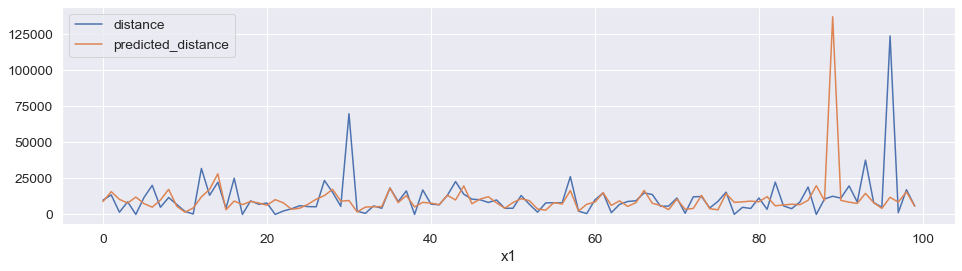

Correlation between actual and predicted distance:  0.20358249753184313


In [49]:
df2 = data_non_eu_ok[["order_id_new","distance","predicted_distance"]][75:175].sort_values(by=['order_id_new']).reset_index(drop=True)
df2['x1'] = df2.index
fig=plt.figure(figsize=(16,4))
ax = plt.gca()
df2.plot(kind="line",x="x1",y="distance",ax=ax)
df2.plot(kind="line",x="x1",y="predicted_distance",ax=ax)
plt.show()
print("Correlation between actual and predicted distance: ", data_non_eu_ok["distance"].corr(data_non_eu_ok["predicted_distance"]))

**Predicted distances differ from actuals significantly. Removing some of the outliers would of course increase the correlation between these 2 variables however this is still very problematic, as distance is one of two variables used for calculating metered_price values.**

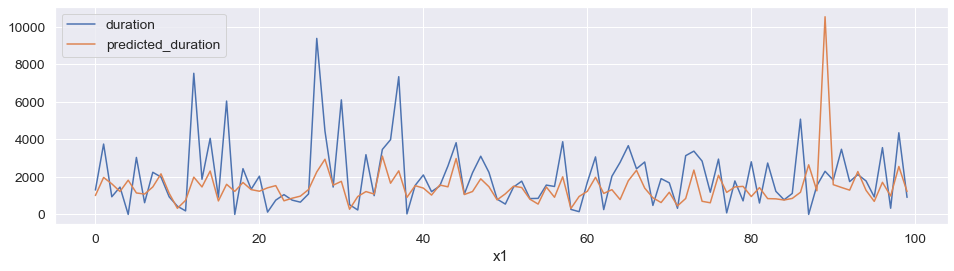

Correlation between actual and predicted duration:  0.2778184757729436


In [50]:
df2 = data_non_eu_ok[["order_id_new","duration","predicted_duration"]][75:175].sort_values(by=['order_id_new']).reset_index(drop=True)
df2['x1'] = df2.index
fig=plt.figure(figsize=(16,4))
ax = plt.gca()
df2.plot(kind="line",x="x1",y="duration",ax=ax)
df2.plot(kind="line",x="x1",y="predicted_duration",ax=ax)
plt.show()
print("Correlation between actual and predicted duration: ", data_non_eu_ok["duration"].corr(data_non_eu_ok["predicted_duration"]))

**Predicted durations differ significantly from actuals. Removing some of the outliers would of course increase the correlation between these 2 variables however this is still very problematic, as duration is one of two variables used for calculating metered_price values.**

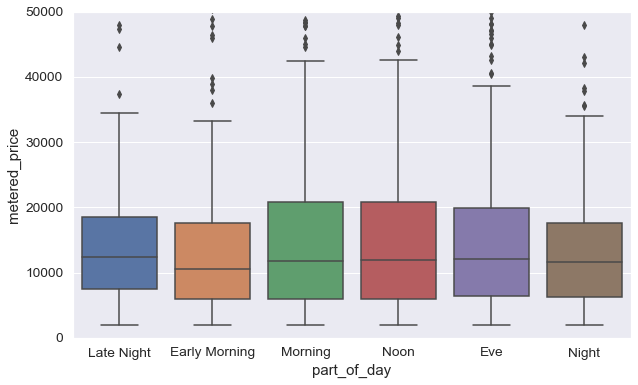

In [51]:
# metered_price vs time_of_day
var = "part_of_day"
data1 = pd.concat([data_non_eu["metered_price"], data_non_eu[var]], axis=1)
f, ax = plt.subplots(figsize=(10, 6))
fig = sns.boxplot(x=var, y="metered_price", data=data1)
fig.axis(ymin=0, ymax=50000);

In non-EU rides done during the first part of the day are more expensive (monring and noon rides). Rides done during night time seem are the cheapest ones.

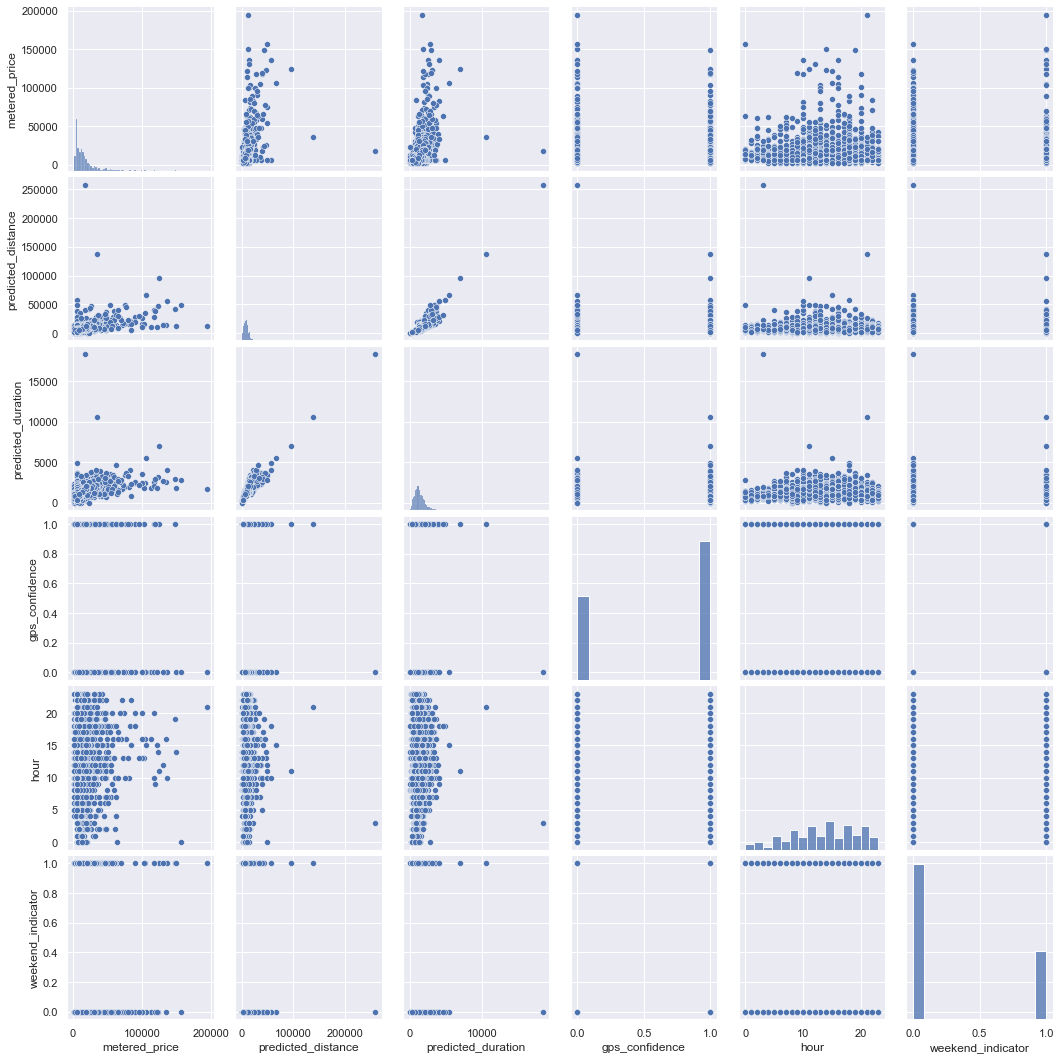

In [52]:
sns.set()
cols = ["metered_price","predicted_distance","predicted_duration","gps_confidence","hour", "weekend_indicator"]
sns.pairplot(data_non_eu[cols], height = 2.5)
plt.show()

### 2.3 Testing with simple models (very top level)

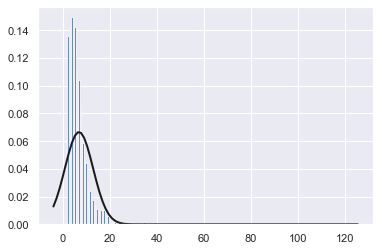

In [53]:
#histogram to check for normal distribution
mu, std = norm.fit(data_eu.metered_price) 
plt.hist(data_eu.metered_price, bins=200, density=True, alpha=0.8, color='b')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.show()

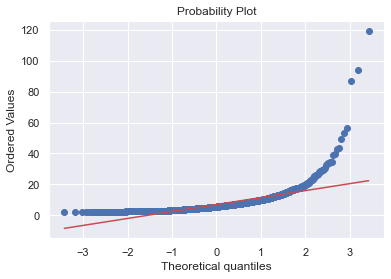

In [54]:
res = stats.probplot(data_eu.metered_price, plot=plt)

metered_price has a strong positive skewness and is peaking at low values - we should do some transformations on it before using it in our models

In [55]:
eu_train, eu_test = train_test_split(data_eu, test_size=0.2)

In [56]:
pd.options.mode.chained_assignment = None  # default='warn'
# Let's see if log tranformation will resolve our dependent variable issues
eu_train.metered_price = np.log(eu_train.metered_price)
eu_test.metered_price = np.log(eu_test.metered_price)

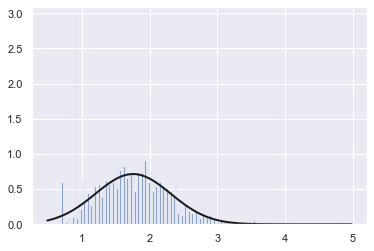

In [57]:
#histogram to check for normal distribution
mu, std = norm.fit(eu_train.metered_price) 
plt.hist(eu_train.metered_price, bins=200, density=True, alpha=0.6, color='b')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.show()

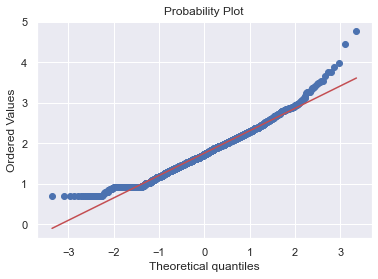

In [58]:
res = stats.probplot(eu_train.metered_price, plot=plt)

Not perfect but better

In [59]:
#convert categorical variables into dummy - not going into app versions and devices 
eu_train = pd.get_dummies(eu_train, prefix=["part_of_day"], columns=["part_of_day"])
eu_test = pd.get_dummies(eu_test, prefix=["part_of_day"], columns=["part_of_day"])
eu_train.head(10)

,order_try_id_new,calc_created,metered_price,gps_confidence,entered_by,prediction_price_type,predicted_distance,predicted_duration,change_reason_pricing,rider_app_version,order_state,order_try_state,driver_app_version,driver_device_uid_new,device_name,fraud_score,date,hour,weekday,weekend_indicator,part_of_day_Late Night,part_of_day_Early Morning,part_of_day_Morning,part_of_day_Noon,part_of_day_Eve,part_of_day_Night
3701,3431,2020-03-06 23:31:05,1.278152,1,client,upfront,10117.0,1186.0,NaN,CA.5.45,finished,finished,DA.4.39,362,HUAWEI KOB-L09,0.0,2020-03-06,23,4,0,0,0,0,0,0,1
2689,2615,2020-02-27 11:35:12,0.916291,1,client,upfront,822.0,289.0,NaN,CA.5.27,finished,finished,DA.4.31,441,Samsung SM-G935F,0.0,2020-02-27,11,3,0,0,0,1,0,0,0
415,3174,2020-03-04 08:21:27,1.764731,1,client,upfront,4549.0,692.0,NaN,CA.5.43,finished,finished,DA.4.29,1996,Samsung SM-A105FN,-180.0,2020-03-04,8,2,0,0,1,0,0,0,0
1339,300,2020-02-04 22:37:09,1.269761,1,client,upfront,4144.0,527.0,NaN,CI.4.17,finished,finished,DA.4.30,1251,HUAWEI VNS-L21,0.0,2020-02-04,22,1,0,0,0,0,0,0,1
167,2633,2020-02-27 16:00:47,2.325325,1,client,upfront,6549.0,1698.0,NaN,CA.5.45,finished,finished,DA.4.31,2043,Sony G8141,-696.0,2020-02-27,16,3,0,0,0,0,1,0,0
818,229,2020-02-04 09:33:37,1.499623,1,client,upfront,3906.0,546.0,NaN,CA.5.42,finished,finished,DA.4.37,299,Samsung SM-G965F,-1846.0,2020-02-04,9,1,0,0,0,1,0,0,0
1449,738,2020-02-09 00:07:11,2.184927,1,client,upfront,13338.0,1233.0,NaN,CA.5.43,finished,finished,DA.4.39,2089,HUAWEI MAR-LX1A,0.0,2020-02-09,0,6,1,1,0,0,0,0,0
309,3730,2020-03-09 19:05:15,1.305626,1,client,upfront,3414.0,540.0,NaN,CI.4.19,finished,finished,DA.4.30,854,HUAWEI ANE-LX1,-614.0,2020-03-09,19,0,0,0,0,0,0,1,0
3821,2101,2020-02-22 01:48:32,1.098612,1,client,upfront,2033.0,300.0,NaN,CI.4.19,finished,finished,DA.4.39,641,HUAWEI EVA-L19,0.0,2020-02-22,1,5,1,1,0,0,0,0,0
913,2598,2020-02-27 06:40:55,1.456287,1,client,upfront,2065.0,803.0,NaN,CI.4.03,finished,finished,DA.4.39,1140,Samsung SM-G965F,-1252.0,2020-02-27,6,3,0,0,1,0,0,0,0


#### 2.3.1 Linear Regression

In [60]:
# Create a Linear regressor
lm = LinearRegression()

# Select variables for the model
model_vars = ["predicted_distance","predicted_duration","gps_confidence","part_of_day_Late Night","part_of_day_Night"]
X_eu_train = eu_train[model_vars]
y_train = eu_train.metered_price

# Train the model using the training sets 
lm.fit(X_eu_train, y_train)

LinearRegression()

In [61]:
# Value of y intercept
lm.intercept_

1.1599152271460764

In [62]:
#Converting the coefficient values to a dataframe
coeffcients = pd.DataFrame([X_eu_train.columns,lm.coef_]).T
coeffcients = coeffcients.rename(columns={0: 'Attribute', 1: 'Coefficients'})
coeffcients

,Attribute,Coefficients
0,predicted_distance,0.00001
1,predicted_duration,0.000689
2,gps_confidence,-0.080454
3,part_of_day_Late Night,0.084473
4,part_of_day_Night,0.073293


In [63]:
# Model prediction on train data
y_pred = lm.predict(X_eu_train)

In [64]:
# Model Evaluation
print('R^2:',metrics.r2_score(y_train, y_pred))
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_train, y_pred))*(len(y_train)-1)/(len(y_train)-X_eu_train.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_train, y_pred))
print('MSE:',metrics.mean_squared_error(y_train, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, y_pred)))

R^2: 0.5276517828073335
Adjusted R^2: 0.5263182192353609
MAE: 0.2778991130297413
MSE: 0.14710200792270361
RMSE: 0.3835387958508287


Results from this very simple linear model are not great. More effort would have to be put in to increase the model results. Also having more datapoints would help. 

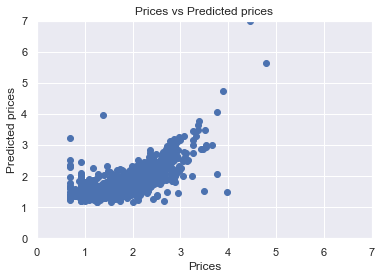

In [65]:
# Metered price vs upfront prediction
plt.scatter(y_train, y_pred)
plt.xlabel("Prices")
plt.ylabel("Predicted prices")
plt.title("Prices vs Predicted prices")
plt.axis(ymin=0, ymax=7)
plt.axis(xmin=0, xmax=7)
plt.show()

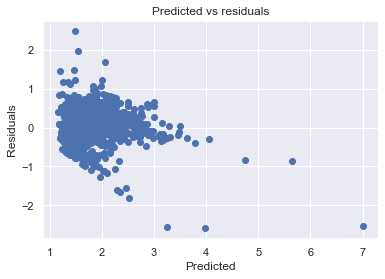

In [66]:
# overview of residuals
plt.scatter(y_pred,y_train-y_pred)
plt.title("Predicted vs residuals")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.show()

C:\Users\rkask\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


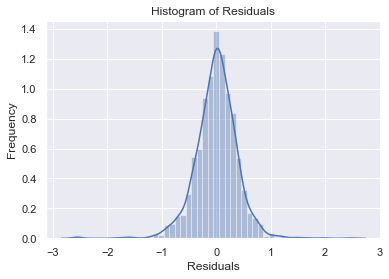

In [67]:
# Checking the normality of errors
sns.distplot(y_train-y_pred)
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

Residuals are normally distributed - *that's good at least*

In [68]:
# Predicting Test data with the model
X_eu_test = eu_test[model_vars]
y_test = eu_test.metered_price
y_test_pred = lm.predict(X_eu_test)

In [69]:
# Model Evaluation
acc_linreg = metrics.r2_score(y_test, y_test_pred)
print('R^2:', acc_linreg)
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_test, y_test_pred))*(len(y_test)-1)/(len(y_test)-X_eu_test.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_test, y_test_pred))
print('MSE:',metrics.mean_squared_error(y_test, y_test_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

R^2: 0.4372545021733706
Adjusted R^2: 0.43084510014801036
MAE: 0.2955702962684903
MSE: 0.20028508960666278
RMSE: 0.44753222186415


Very similar results to training results -> no overfitting - *also a good thing*

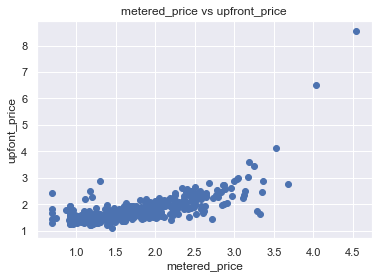

In [70]:
# Visualizing the differences between metered_price and upfront_price
plt.scatter(y_test, y_test_pred)
plt.xlabel("metered_price")
plt.ylabel("upfont_price")
plt.title("metered_price vs upfront_price")
plt.show()

#### 2.3.2 Random Forest

In [71]:
# Create a Random Forest Regressor
reg = RandomForestRegressor()

#model_vars = ["predicted_distance","predicted_duration","gps_confidence","part_of_day_Late Night","part_of_day_Night"]
model_vars = ["predicted_distance","predicted_duration","gps_confidence","part_of_day_Late Night","part_of_day_Night"]
X_eu_train = eu_train[model_vars]

# Train the model using the training sets 
reg.fit(X_eu_train, y_train)

RandomForestRegressor()

In [72]:
# Model prediction on train data
y_pred = reg.predict(X_eu_train)

In [73]:
# Model Evaluation
print('R^2:',metrics.r2_score(y_train, y_pred))
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_train, y_pred))*(len(y_train)-1)/(len(y_train)-X_eu_train.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_train, y_pred))
print('MSE:',metrics.mean_squared_error(y_train, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, y_pred)))

R^2: 0.9293760601628809
Adjusted R^2: 0.9291766701576942
MAE: 0.1035631072462408
MSE: 0.021994204655195936
RMSE: 0.14830443235182128


Initial results for a simple RFR model seem great but let's look at the results from other angles as well

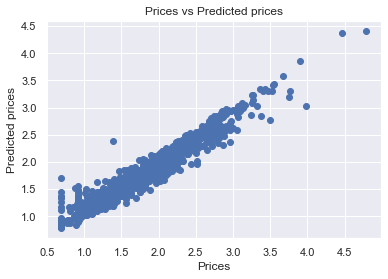

In [74]:
# Visualizing the differences between actual prices and predicted values
plt.scatter(y_train, y_pred)
plt.xlabel("Prices")
plt.ylabel("Predicted prices")
plt.title("Prices vs Predicted prices")
plt.show()

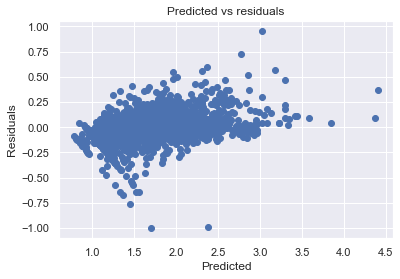

In [75]:
# Checking residuals
plt.scatter(y_pred,y_train-y_pred)
plt.title("Predicted vs residuals")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.show()

C:\Users\rkask\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


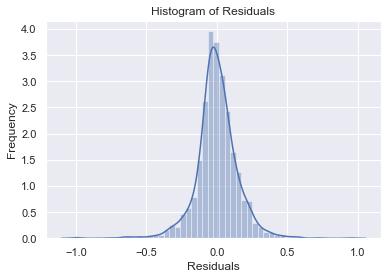

In [76]:
# Checking the normality of errors
sns.distplot(y_train-y_pred)
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

Residuals are normally distributed - *again, that's good at least*

In [77]:
# Predicting Test data with the model
X_eu_test = eu_test[model_vars]
y_test_pred = reg.predict(X_eu_test)

In [78]:
# Model Evaluation
acc_rf = metrics.r2_score(y_test, y_test_pred)
print('R^2:', acc_rf)
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_test, y_test_pred))*(len(y_test)-1)/(len(y_test)-X_eu_test.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_test, y_test_pred))
print('MSE:',metrics.mean_squared_error(y_test, y_test_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

R^2: 0.5570864903889063
Adjusted R^2: 0.5520419173865021
MAE: 0.28759309935166044
MSE: 0.15763604027586348
RMSE: 0.3970340543024785


Results are far from the ones seen on the training set. We are probably overfitting with the model. Therefor our initial assessment that the simple RFR model was performing well was actually misleading. We would need to dig deeper.

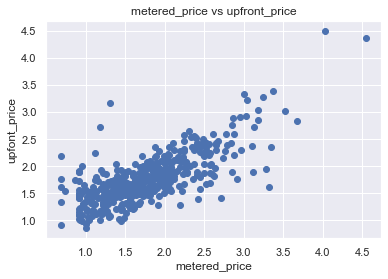

In [79]:
# Visualizing the differences between metered_price and upfront_price
plt.scatter(y_test, y_test_pred)
plt.xlabel("metered_price")
plt.ylabel("upfont_price")
plt.title("metered_price vs upfront_price")
plt.show()

## 3. Conclusions

## Analysis - Opportunities to improve upfront price predictions

The purpose of this analysis was to find opportunities to improve the precision of upfront pricing predictions. For that a dataset containing data from 4 166 unique rides taken place between 01.02.2020 and 13.03.2020 was given. Out of these 4 166 rides 19 had a missing metered price value and they were excluded from the further analysis. However it should be looked into why these datapoints have occured.

After removing these mentioned 19 rides we were left with the following division of rides:

| Region | Total no of rides | Rides with missing Upfront Price | No of rides where metered price was used |
| --- | --- | --- | --- |
| EU | 2 465 | 210 (8.5%) | 971 (39.3%) |
| non-EU | 1 682 | 1 010 (60.0%) | 1386 (82.4%) |

The high number of missing Upfront price values for non-EU region was one of the first peculiarities noticed. Further investigation revealed that most of the missing upfront prices for non-EU started to appear on 17.02.2020.

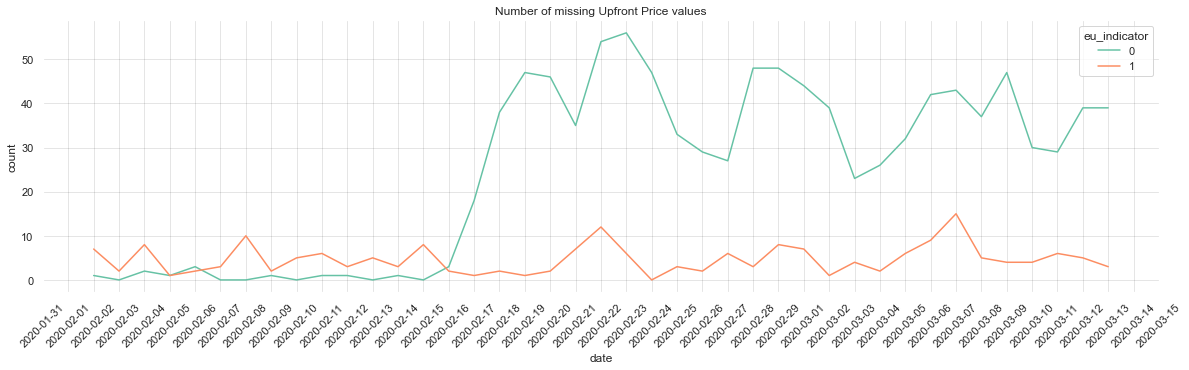

In [80]:
missing_values_agr = data_original.upfront_price.isnull().groupby([data_original["eu_indicator"],data_original["date"]]).sum().astype(int).reset_index(name="count")
fig=plt.figure(figsize=(20,5))
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
plt.rc('grid', linestyle="-", color='black', alpha=0.1)
ax = sns.lineplot(data=missing_values_agr, x="date", y="count", hue="eu_indicator", palette="Set2")
plt.xticks(rotation=45)
plt.grid(True)
plt.title("Number of missing Upfront Price values")
loc = plticker.MultipleLocator(base=1.0)
ax.xaxis.set_major_locator(loc)
plt.show(ax)

Figuring out the reasons behind missing values for non-EU rides starting from 17.02.2020 should get the highest priority. Especially if this dataset is also serving as an input for learning for the current price prediction models. 

The fact that starting from 17.02.2020 values for price prediction type for non-EU rides changed from *upfront* to *prediction* hints that a new price prediction model might have been implemented for non-EU rides on that date and the ETL process needs to modified.

Closer look at the current price predictions revealed that for EU rides price prediction are not too far off however for non-EU rides the predictions are very far off. Results can be summarized as follows:

| Region | Total no of rides included | Average price | $ R^2 $ | Mean Average Error (MAE) | Mean Absolute Percentage Error (MAPE) |
| --- | --- | --- | --- | --- | --- |
| EU | 2 198 | 6.95 | 0.79 | 1.31 | 21.3% | 
| non-EU | 637 | 17 905 | -0.81 | 9072 | 49.9% |

Note! These results are based on rides with a single destination input by the user (dest_change_number=1)

**In order to increase overall level of upfront price predictions the focus should be on improving the prediction model for non-EU rides. The main issue with non-EU rides however is that predicted distance and duration for these rides differ significantly from actual distance and duration. And as metered price is derived only from actual distance and duration this substantially complicates predicting the price accurately.**

Let's look at predicted **duration** precision between EU and non-EU rides visually:

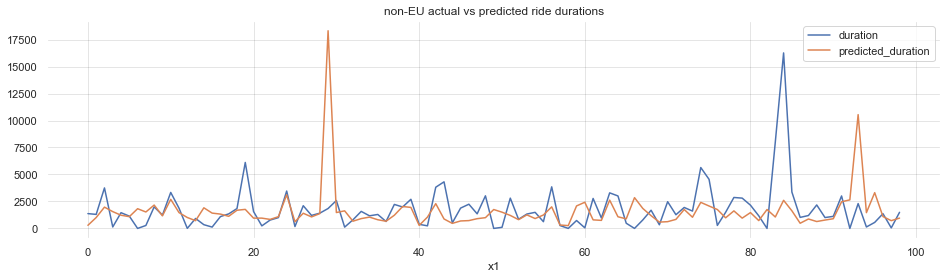

In [81]:
df2 = data_non_eu_ok[["order_id_new","duration","predicted_duration"]][1:100].sort_values(by=['order_id_new']).reset_index(drop=True)
df2['x1'] = df2.index
fig=plt.figure(figsize=(16,4))
plt.title("non-EU actual vs predicted ride durations")
ax = plt.gca()
df2.plot(kind="line",x="x1",y="duration",ax=ax)
df2.plot(kind="line",x="x1",y="predicted_duration",ax=ax)
plt.show()

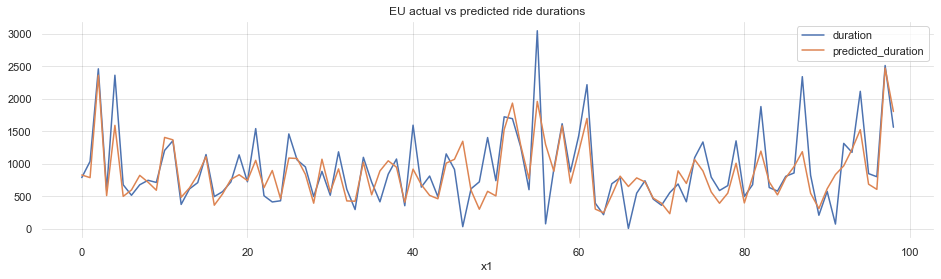

In [82]:
df2 = data_eu_ok[["order_id_new","duration","predicted_duration"]][1:100].sort_values(by=['order_id_new']).reset_index(drop=True)
df2['x1'] = df2.index
fig=plt.figure(figsize=(16,4))
plt.title("EU actual vs predicted ride durations")
ax = plt.gca()
df2.plot(kind="line",x="x1",y="duration",ax=ax)
df2.plot(kind="line",x="x1",y="predicted_duration",ax=ax)
plt.show()

We can clearly see from the charts that for non-EU rides the accuracy in predicting the ride duration is very low. The same cannot be said for EU rides (the picture is similar when it comes to actual and predicted distances). **Hence in order to increase the precision for non-EU rides we would first need to increase the accuracy of predicted distance and duration.**

### Opportunities for improving the upfront pricing precision
* Figure out the reasons behind missing values in the dataset (and duplicates if these might cause any troubles)
    * Some rides are missing metered_price values
    * Huge amount of rides are missing upfront_price values for non-EU rides (starting from 17.02.2020)
    * 777 duplicate values where found from the initial dataset (15.7%) - need to make sure that these are not included in the models development
* Focus on increasing the upfront pricing precision for non-EU rides
    * **Look into ways of improving the accuracy of predicting ride distance and duration before dealing with the upfront price prediction models (Top 1 opportunity)**
    * Including different timestamp features (e.g which part of the day the ride was taken) into upfront price prediction models might help to increase their accuracy